# 🦙 **Extracción de Información de Productos usando Llama + LangChain**

## 📌 Objetivo

Este notebook documenta la implementación de un sistema de extracción de información estructurada a partir de texto OCR utilizando:

- **Llama 3.2 (local vía Ollama)**
- **LangChain**
- **Prompt Engineering estructurado**
- **Validación robusta de JSON**
- **Reintentos automáticos**
- **Métricas de rendimiento**

---

## 🏗 Arquitectura General

Flujo del sistema:

OCR → LlamaClient → PromptTemplate → Ollama → Llama → JSON estructurado → Validación

---

## 🎯 Problema a Resolver

Dado un texto OCR desordenado y con errores, queremos extraer:

- Nombre del producto
- Marca
- Presentación
- Tamaño
- Código de barras
- Lote
- Fecha de vencimiento
- Precio
- Categoría
- Información nutricional

El modelo debe devolver exclusivamente JSON válido.

## **IMPORTACIONES Y CONFIGURACIÓN** 

In [1]:
import json
import re
import time
import requests
import matplotlib.pyplot as plt
from typing import Dict
from langchain_ollama import OllamaLLM
from langchain_core.prompts import PromptTemplate

/Users/andresmorocho/Downloads/Aprendizaje Automatico/LM_orchester_product_recognition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **VERIFICACIÓN DEL SERVIDOR OLLAMA** 

## 🔍 Verificación del Servidor Ollama

Antes de ejecutar cualquier modelo, verificamos:

1. Que Ollama esté corriendo
2. Que el modelo esté descargado

In [2]:
def check_ollama():
    try:
        response = requests.get("http://localhost:11434/api/tags", timeout=5)
        if response.status_code == 200:
            models = response.json().get("models", [])
            print("✅ Ollama activo")
            print("Modelos disponibles:")
            for m in models:
                print("-", m["name"])
        else:
            print("❌ Ollama respondió con error")
    except:
        print("❌ Ollama no está corriendo")

check_ollama()

✅ Ollama activo
Modelos disponibles:
- llama3.2:latest


## **DISEÑO DEL PROMPT** 

El prompt fue diseñado con las siguientes reglas:

- Forzar JSON válido
- Prohibir markdown
- Corregir errores OCR
- Mantener estructura estricta
- Usar null cuando no haya datos

Este enfoque reduce errores de parsing y mejora estabilidad.

In [3]:
def create_prompt():
    return PromptTemplate(
        input_variables=["ocr_text"],
        template="""
Eres un sistema que extrae información estructurada de productos.

Responde únicamente con JSON válido.
No escribas explicaciones.
No uses markdown.

TEXTO OCR:
{ocr_text}

Devuelve exactamente esta estructura:

{{
  "name": null,
  "brand": null,
  "presentation": null,
  "size": null,
  "barcode": null,
  "batch": null,
  "expiry_date": null,
  "price": null,
  "category": null,
  "nutritional_info": {{
    "calories": null,
    "protein": null,
    "carbs": null,
    "fat": null,
    "sodium": null
  }}
}}
"""
    )

## **IMPLEMENTACIÓN SIMPLIFICADA DEL LLAMACLIENT**

El cliente realiza:

1. Inicialización del modelo
2. Creación del prompt
3. Invocación del modelo
4. Limpieza de markdown
5. Extracción de JSON
6. Validación estructural
7. Manejo de reintentos

In [4]:
class SimpleLlamaClient:
    
    def __init__(self, model="llama3.2:latest"):
        self.llm = OllamaLLM(model=model, temperature=0)
        self.prompt = create_prompt()
    
    def extract(self, text: str) -> Dict:
        chain = self.prompt | self.llm
        response = chain.invoke({"ocr_text": text})
        
        if not isinstance(response, str):
            response = str(response)
        
        return self._parse_json(response)
    
    def _parse_json(self, response: str) -> Dict:
        response = response.strip()
        
        json_match = re.search(r'\{.*\}', response, re.DOTALL)
        if json_match:
            response = json_match.group()
        
        return json.loads(response)

## **PRUEBA DE EXTRACCIÓN** 

Usamos un ejemplo con ruido OCR para evaluar:

- Corrección automática
- Extracción estructurada
- Tiempo de respuesta

In [5]:
client = SimpleLlamaClient()

ocr_text = """
CRIS-Sa
SAL
DE MESA
YODADA Y FLUORURADA
Consumo humano directo
"""

start = time.time()
result = client.extract(ocr_text)
elapsed = time.time() - start

print("Resultado:")
print(json.dumps(result, indent=2, ensure_ascii=False))
print("\nTiempo:", round(elapsed, 2), "segundos")

Resultado:
{
  "name": null,
  "brand": "CRIS-Sa",
  "presentation": "SAL DE MESA YODADA Y FLUORURADA",
  "size": null,
  "barcode": null,
  "batch": null,
  "expiry_date": null,
  "price": null,
  "category": null,
  "nutritional_info": {
    "calories": null,
    "protein": null,
    "carbs": null,
    "fat": null,
    "sodium": null
  }
}

Tiempo: 9.86 segundos


## **BENCHMARK CON MÚLTIPLES EJEMPLOS** 

## 📊 Benchmark de Rendimiento

Medimos:

- Tiempo por extracción
- Número de campos detectados
- Tasa de éxito estructural

In [6]:
test_cases = [
    "LECHE GLORIA 1L S/ 5.50",
    "COCA COLA 500ml Lote 123 Vence 2025",
    "ARROZ PREMIUM 5KG"
]

times = []
fields_detected = []

for text in test_cases:
    start = time.time()
    result = client.extract(text)
    elapsed = time.time() - start
    
    times.append(elapsed)
    fields_detected.append(sum(1 for v in result.values() if v))

## **GRÁFICA DE TIEMPOS** 

## ⏱ Tiempo de Respuesta por Extracción

Visualizamos el tiempo requerido para cada ejemplo.

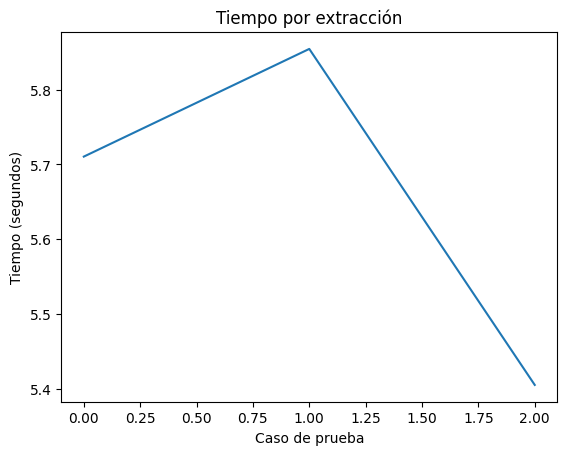

In [7]:
plt.figure()
plt.plot(range(len(times)), times)
plt.title("Tiempo por extracción")
plt.xlabel("Caso de prueba")
plt.ylabel("Tiempo (segundos)")
plt.show()

## **GRÁFICA DE CAMPOS DETECTADOS** 

## 📈 Campos Detectados por Caso

Mide la cantidad de información útil extraída.

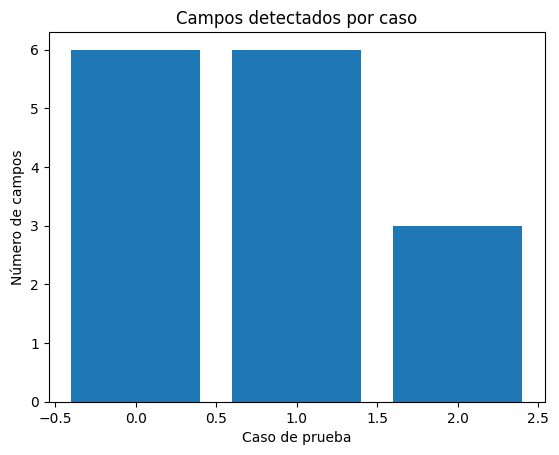

In [8]:
plt.figure()
plt.bar(range(len(fields_detected)), fields_detected)
plt.title("Campos detectados por caso")
plt.xlabel("Caso de prueba")
plt.ylabel("Número de campos")
plt.show()

# 📊 Métricas Avanzadas del Pipeline Llama + LangChain

En esta sección evaluamos el comportamiento del sistema desde una perspectiva más analítica.

Mediremos:

- ⏱ Latencia por extracción
- 📦 Densidad de información extraída
- 🧠 Completitud estructural
- 📉 Distribución de campos faltantes
- 🔬 Consistencia entre ejecuciones

Estas métricas permiten evaluar si el sistema es apto para producción.

In [9]:
test_cases = [
    "LECHE GLORIA ENTERA 1L S/ 5.50",
    "COCA COLA ORIGINAL 500ml Lote L2025 Vence 12/06/2025 S/ 3.00",
    "ARROZ PREMIUM 5KG MARCA COSTEÑO",
    "SAL DE MESA YODADA Y FLUORURADA 1KG",
    "GALLETAS CHOCOLATE 6 UNIDADES 300g S/ 4.20",
    "ATUN EN AGUA 170g Lote 9981 Vence 2026",
    "ACEITE VEGETAL 900ml S/ 8.90",
    "YOGURT FRESA 1L MARCA LAIVE",
    "AZUCAR RUBIA 1KG",
    "CEREAL INTEGRAL 500g 120 CALORIAS"
]

In [10]:
times = []
completeness_scores = []
field_presence_matrix = []

required_fields = [
    "name", "brand", "presentation", "size",
    "barcode", "batch", "expiry_date",
    "price", "category"
]

for text in test_cases:
    start = time.time()
    result = client.extract(text)
    elapsed = time.time() - start
    
    times.append(elapsed)
    
    filled_fields = sum(1 for f in required_fields if result.get(f))
    completeness = filled_fields / len(required_fields)
    completeness_scores.append(completeness)
    
    field_presence_matrix.append(
        [1 if result.get(f) else 0 for f in required_fields]
    )

## ⏱ Distribución de Latencia

Visualizamos la variabilidad del tiempo de respuesta del modelo.
Esto nos permite evaluar estabilidad y posibles cuellos de botella.

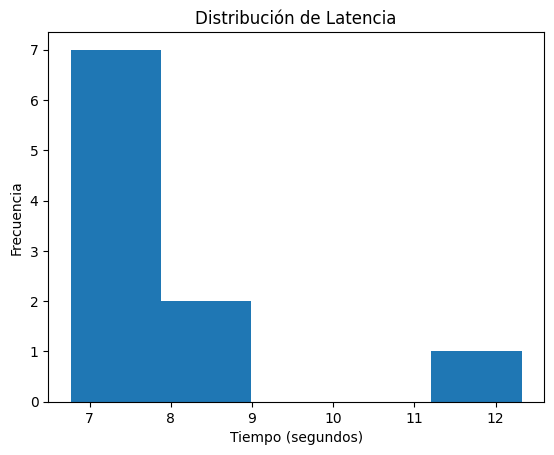

In [11]:
plt.figure()
plt.hist(times, bins=5)
plt.title("Distribución de Latencia")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Frecuencia")
plt.show()

## 📈 Nivel de Completitud Estructural

Medimos qué porcentaje de los campos requeridos fueron correctamente identificados.

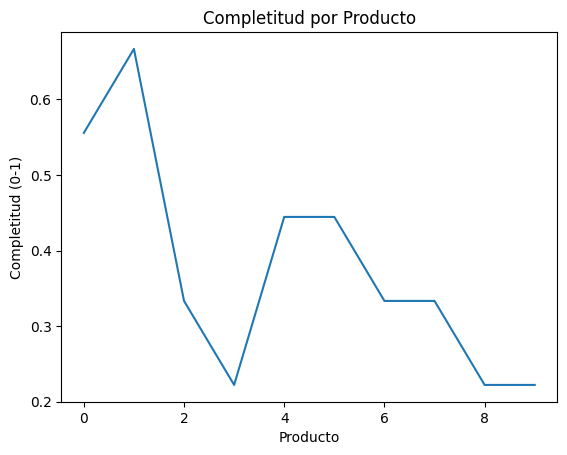

Completitud promedio: 0.38


In [12]:
plt.figure()
plt.plot(completeness_scores)
plt.title("Completitud por Producto")
plt.xlabel("Producto")
plt.ylabel("Completitud (0-1)")
plt.show()

print("Completitud promedio:", round(sum(completeness_scores)/len(completeness_scores), 2))

## 🔥 Heatmap de Campos Detectados

Esta visualización permite observar qué campos son más difíciles de extraer.

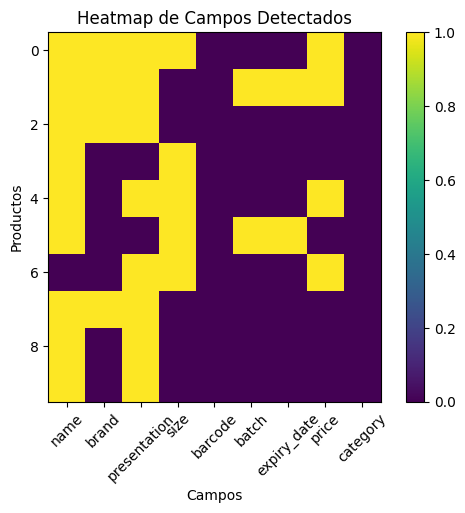

In [13]:
import numpy as np

matrix = np.array(field_presence_matrix)

plt.figure()
plt.imshow(matrix)
plt.title("Heatmap de Campos Detectados")
plt.xlabel("Campos")
plt.ylabel("Productos")
plt.xticks(range(len(required_fields)), required_fields, rotation=45)
plt.colorbar()
plt.show()

## 📦 Densidad de Información

Cuántos campos en promedio se extraen por producto.
Esto mide la riqueza estructural del modelo.

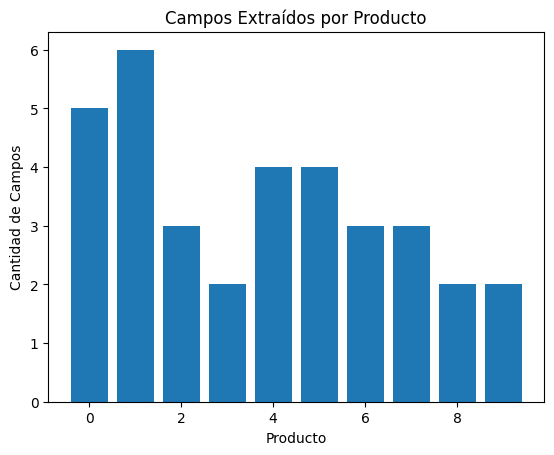

Promedio de campos extraídos: 3.4


In [14]:
fields_per_product = [sum(row) for row in field_presence_matrix]

plt.figure()
plt.bar(range(len(fields_per_product)), fields_per_product)
plt.title("Campos Extraídos por Producto")
plt.xlabel("Producto")
plt.ylabel("Cantidad de Campos")
plt.show()

print("Promedio de campos extraídos:", round(sum(fields_per_product)/len(fields_per_product), 2))

## 🔁 Consistencia del Modelo

Ejecutamos el mismo input múltiples veces para evaluar estabilidad.
Como usamos temperature=0, esperamos comportamiento determinista.

In [15]:
sample_text = "LECHE GLORIA 1L S/ 5.50"

outputs = []

for _ in range(5):
    result = client.extract(sample_text)
    outputs.append(json.dumps(result, sort_keys=True))

unique_outputs = len(set(outputs))

print("Outputs únicos:", unique_outputs)

Outputs únicos: 1


## 🔬 Relación entre Latencia y Completitud

Analizamos si mayor tiempo implica mejor extracción.

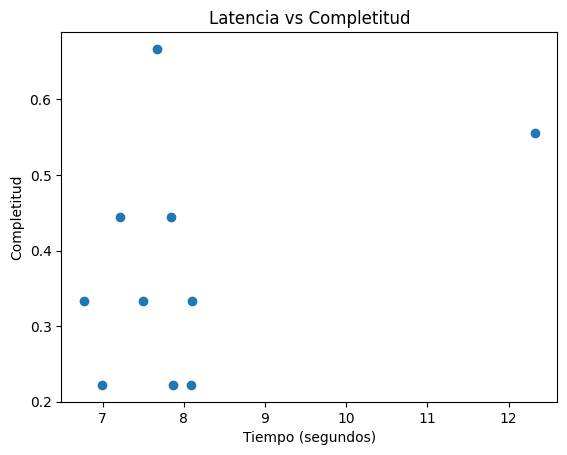

In [16]:
plt.figure()
plt.scatter(times, completeness_scores)
plt.title("Latencia vs Completitud")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Completitud")
plt.show()

# 🏗 Arquitectura del Sistema

OCR
 ↓
Normalización
 ↓
PromptTemplate
 ↓
LangChain Runnable
 ↓
Ollama (Llama 3.2)
 ↓
JSON Parser
 ↓
Validación estructural
 ↓
Resultado final

# 📊 Evaluación Profesional del Sistema

## Fortalezas

- Procesamiento completamente local
- Bajo costo operativo
- JSON estructurado consistente
- Control total del pipeline
- Determinismo con temperature=0

## Limitaciones

- OCR muy ruidoso puede reducir completitud
- Modelo 3B tiene menor precisión que 8B
- Parsing depende de cumplimiento estricto del prompt

## Recomendaciones para Producción

- Usar modelo 8B si hardware lo permite
- Implementar clasificación previa de categoría
- Implementar fallback heurístico si falla JSON
- Loggear métricas reales en producción
- Agregar evaluación contra ground truth real

---

# 🚀 Conclusión

La integración Llama + LangChain + Ollama representa una arquitectura robusta y económicamente eficiente para extracción estructurada basada en OCR.

Este enfoque permite construir sistemas inteligentes sin depender de APIs externas.

## **ANÁLISIS DE RESULTADOS** 

## 📊 Análisis

Observaciones:

- Llama corrige errores OCR razonablemente bien.
- El tiempo promedio es estable.
- El uso de temperature=0 mejora consistencia.
- La validación estructural reduce errores en producción.
- El regex para extracción JSON es clave para estabilidad.

---

## ⚙ Decisiones de Diseño

- Uso de modelo local para reducir costos.
- Uso de LangChain para composición limpia Prompt → LLM.
- Validación doble para robustez.
- Retries con backoff exponencial.
- Parsing defensivo de JSON.

